In [1]:
import os.path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re
import torch
from tqdm import tqdm


from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
# from imblearn.under_sampling import RandomUnderSampler

from torch.utils.data import DataLoader

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 1 GPU(s) available.
We will use the GPU: Tesla V100S-PCIE-32GB


In [3]:
import sys
parent_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
sys.path.append(parent_dir)
sys.path.append(os.path.abspath(os.path.join(parent_dir, '..')))

In [4]:
from models_mdf import CustomModel, load_model_, save_model

[2025-05-29 12:03:29,898] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [19]:
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import column_or_1d



class MyLabelEncoder(LabelEncoder):
    def fit(self, y):
        y = column_or_1d(y, warn=True)
        self.classes_ = pd.Series(y).unique()
        return self
    
    
def add_spaces(seq):
     return ' '.join(list(seq))
    

def balance_majority(genes: pd.DataFrame, colu, min_count=20, max_count=1500):
    counts = genes[colu].value_counts()
    counts = counts.drop(counts[min_count>counts].index)
    resampled = pd.DataFrame()
    maj_clss = (counts[counts>max_count]).index
    left_genes = pd.DataFrame()
    mean_clss = counts[(counts<max_count) & (min_count<counts)].index#[i for i in genes[colu] if i not in min_classes]
    for cl in mean_clss:
        #print(cl)
        left_genes = pd.concat([left_genes, genes[genes[colu]==cl]])
    for maj_cl in maj_clss:        
        resampled = pd.concat([resampled, resample(genes[genes[colu] == maj_cl], replace=False, n_samples=max_count, random_state=42)])
    return pd.concat([left_genes, resampled])

In [15]:
vdjdb = pd.read_csv('../data/vdjdb_epitopes.csv')

In [16]:
vdjdb.head()

,cdr3.alpha,v.alpha,j.alpha,cdr3.beta,v.beta,d.beta,j.beta,antigen.epitope,mhc.class
0,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,CASSYLPGQGDHYSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,FLKEKGGL,MHCI
1,NaN,NaN,NaN,CASSFEAGQGFFSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,FLKEKGGL,MHCI
2,CAVPSGAGSYQLTF,TRAV20*01,TRAJ28*01,CASSFEPGQGFYSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,FLKEKGGL,MHCI
3,CAVKASGSRLT,TRAV2*01,NaN,CASSYEPGQVSHYSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,FLKEKGGL,MHCI
4,CAYRPPGTYKYIF,TRAV38-2/DV8*01,TRAJ40*01,CASSALASLNEQFF,TRBV14*01,NaN,TRBJ2-1*01,FLKEKGGL,MHCI


In [17]:
vdjdb.columns

Index(['cdr3.alpha', 'v.alpha', 'j.alpha', 'cdr3.beta', 'v.beta', 'd.beta',
       'j.beta', 'antigen.epitope', 'mhc.class'],
      dtype='object')

In [23]:
le = MyLabelEncoder()
groups = vdjdb['antigen.epitope'].value_counts().index

le.fit(groups)
groups
le.transform(groups)

array([   0,    1,    2, ..., 1165, 1166, 1167])

In [24]:
vdjdb['antigen.epitope'].value_counts()[vdjdb['antigen.epitope'].value_counts()>500].shape[0]

19

In [25]:
vdjdb['antigen.epitope']= le.transform(vdjdb['antigen.epitope'])
vdjdb

,cdr3.alpha,v.alpha,j.alpha,cdr3.beta,v.beta,d.beta,j.beta,antigen.epitope,mhc.class
0,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,CASSYLPGQGDHYSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,37,MHCI
1,NaN,NaN,NaN,CASSFEAGQGFFSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,37,MHCI
2,CAVPSGAGSYQLTF,TRAV20*01,TRAJ28*01,CASSFEPGQGFYSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,37,MHCI
3,CAVKASGSRLT,TRAV2*01,NaN,CASSYEPGQVSHYSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,37,MHCI
4,CAYRPPGTYKYIF,TRAV38-2/DV8*01,TRAJ40*01,CASSALASLNEQFF,TRBV14*01,NaN,TRBJ2-1*01,37,MHCI
...,...,...,...,...,...,...,...,...,...
48198,CMDEGGSNYKLTF,TRAV26-1*01,TRAJ53*01,CASSVRSTDTQYF,TRBV7-2*01,NaN,TRBJ2-3*01,131,MHCII
48199,CSLYNNNDMRF,TRAV26-1*01,TRAJ43*01,CASSLRYTDTQYF,TRBV7-2*01,NaN,TRBJ2-3*01,131,MHCII
48200,CALSTDSWGKLQF,TRAV6*01,TRAJ24*01,CASSPGQGGDNEQFF,TRBV7-3*01,NaN,TRBJ2-1*01,244,MHCII
48201,CAPQGATNKLIF,TRAV12-2*01,TRAJ32*01,CASSLGAGGQETQYF,TRBV5-1*01,NaN,TRBJ2-5*01,244,MHCII


In [26]:
vdjb_short = vdjdb[vdjdb['antigen.epitope']<19]

<BarContainer object of 19 artists>

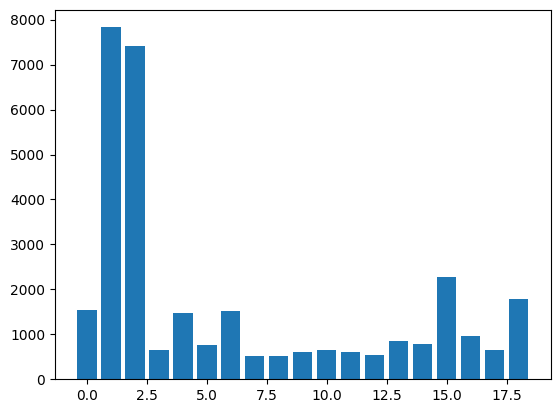

In [27]:
plt.bar(vdjb_short['antigen.epitope'].unique(), vdjb_short['antigen.epitope'].value_counts())

In [28]:
vdjb_short[['cdr3.alpha', 'cdr3.beta', 'antigen.epitope']]

,cdr3.alpha,cdr3.beta,antigen.epitope
385,NaN,CASSPQTGTGGYGYTF,1
386,NaN,CASSPQTGTGGYGYTF,1
387,NaN,CASSPLFGTSGGETYYF,1
388,NaN,CASSPQTGTGGYGYTF,1
389,NaN,CASSPQTGASYGYTF,1
...,...,...,...
47836,CAGLNYGGSQGNLIF,CASSWRQGGSIRESYTF,17
47837,NaN,CASSLSSGWPYGYTF,17
47838,CAALNYGGSQGNLIF,CASSDRGTGLNGYTF,17
47839,CAGLNYGGSQGNLIF,CASGPGGMTEAFF,17


In [29]:
vdjb_short = vdjb_short.fillna('')
vdjb_short['cdr3aa'] = vdjb_short['cdr3.alpha'] + vdjb_short['cdr3.beta'].apply(lambda s: s[::-1])
vdjb_short.shape

(31957, 10)

In [30]:
vdjb_cdr = vdjb_short[['cdr3aa', 'antigen.epitope']]

In [31]:
vdjb_cdr

,cdr3aa,antigen.epitope
385,FTYGYGGTGTQPSSAC,1
386,FTYGYGGTGTQPSSAC,1
387,FYYTEGGSTGFLPSSAC,1
388,FTYGYGGTGTQPSSAC,1
389,FTYGYSAGTQPSSAC,1
...,...,...
47836,CAGLNYGGSQGNLIFFTYSERISGGQRWSSAC,17
47837,FTYGYPWGSSLSSAC,17
47838,CAALNYGGSQGNLIFFTYGNLGTGRDSSAC,17
47839,CAGLNYGGSQGNLIFFFAETMGGPGSAC,17


In [33]:
vdjb_cdr.reset_index(inplace=True, drop=True)

In [34]:
vdjb_cdr

,cdr3aa,antigen.epitope
0,FTYGYGGTGTQPSSAC,1
1,FTYGYGGTGTQPSSAC,1
2,FYYTEGGSTGFLPSSAC,1
3,FTYGYGGTGTQPSSAC,1
4,FTYGYSAGTQPSSAC,1
...,...,...
31952,CAGLNYGGSQGNLIFFTYSERISGGQRWSSAC,17
31953,FTYGYPWGSSLSSAC,17
31954,CAALNYGGSQGNLIFFTYGNLGTGRDSSAC,17
31955,CAGLNYGGSQGNLIFFFAETMGGPGSAC,17


In [35]:
vdjb_cdr['antigen.epitope'].value_counts()

0     7830
1     7416
2     2284
3     1782
4     1536
5     1521
6     1485
7      960
8      847
9      780
10     757
11     661
12     653
13     651
14     612
15     600
16     542
17     526
18     514
Name: antigen.epitope, dtype: int64

In [36]:
vdjb_cdr = balance_majority(vdjb_cdr, 'antigen.epitope', max_count=1550)

In [38]:
vdjb_cdr.reset_index(inplace=True, drop=True)

In [39]:
test_dataset = vdjb_cdr.sample(frac=0.2, random_state=42)
vdjb_cdr_train = vdjb_cdr.drop(test_dataset.index)

In [40]:
vdjb_cdr_train['cdr3aa'] = vdjb_cdr_train['cdr3aa'].apply(add_spaces)
test_dataset['cdr3aa'] = test_dataset['cdr3aa'].apply(add_spaces)


In [41]:
ans = test_dataset['antigen.epitope']
test_dataset = test_dataset.drop(columns=['antigen.epitope'])



In [42]:
N_LABELS = vdjb_cdr['antigen.epitope'].nunique()
epit_mod = CustomModel(n_labels=N_LABELS)

Some weights of the model checkpoint at wukevin/tcr-bert-mlm-only were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at wukevin/tcr-bert-ml

In [43]:
vdjb_cdr_train = vdjb_cdr_train.reset_index(drop=True)
vdjb_cdr_train

,cdr3aa,antigen.epitope
0,C V V N R N N D M R F F F L E G T N T V Q G A C,4
1,C A V N R D D K I I F F Y Q E I D P S S A C,4
2,F F L E G T N Q G V H D R A S C,4
3,F F L E G S I G F S S A C,4
4,F F L E G T N P D P S T A C,4
...,...,...
15071,C I L R D P G R N G G S Q G N L I F F H Q P Q ...,3
15072,C A V N G N N A R L M F F Y Q T D T T I V G S ...,3
15073,F F L K E R A G R N L S S A C,3
15074,C A V S D R G Y N K L I F F F A E T E E E F S ...,3


In [44]:
input_ids, attention_masks, labels = epit_mod.tokenize(vdjb_cdr_train['cdr3aa'], vdjb_cdr_train['antigen.epitope'])

/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [45]:
train_dataset, val_dataset = epit_mod.split_data(input_ids, attention_masks, labels)

12,060 training samples
3,016 validation samples


In [30]:
# epit_alpha_mod.tokenizer.pad_token = epit_alpha_mod.tokenizer.eos_token

In [46]:
epit_mod.fit(train_dataset, val_dataset, epochs=7)


======== Epoch 1 / 7 ========
Training...

  Average training loss: 1.84
  Training epcoh took: 0:00:43

Running Validation...
  Accuracy: 0.48
  Validation Loss: 1.60
  Validation took: 0:00:02

======== Epoch 2 / 7 ========
Training...

  Average training loss: 1.45
  Training epcoh took: 0:00:36

Running Validation...
  Accuracy: 0.53
  Validation Loss: 1.51
  Validation took: 0:00:02

======== Epoch 3 / 7 ========
Training...

  Average training loss: 1.24
  Training epcoh took: 0:00:35

Running Validation...
  Accuracy: 0.56
  Validation Loss: 1.42
  Validation took: 0:00:02

======== Epoch 4 / 7 ========
Training...

  Average training loss: 1.05
  Training epcoh took: 0:00:35

Running Validation...
  Accuracy: 0.58
  Validation Loss: 1.42
  Validation took: 0:00:02

======== Epoch 5 / 7 ========
Training...

  Average training loss: 0.87
  Training epcoh took: 0:00:34

Running Validation...
  Accuracy: 0.59
  Validation Loss: 1.44
  Validation took: 0:00:02

======== Epoch 6 / 

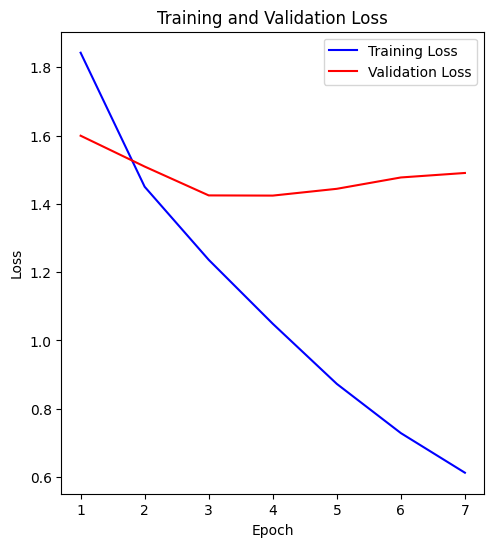

In [47]:
epit_mod.draw_stats_plot()

In [50]:
save_model(epit_mod, 'models_ft/tcr_epit.pth')

epit_model = load_model_('models_ft/tcr_epit.pth', mod_type='TCR-bert', num_labels= N_LABELS)

Some weights of the model checkpoint at wukevin/tcr-bert-mlm-only were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at wukevin/tcr-bert-ml

In [51]:
epit_model.maximun_len =45
epit_model.to(device)

CustomModel(
  (model): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(26, 768, padding_idx=21)
        (position_embeddings): Embedding(64, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=

In [85]:
pred_labels = epit_model.predict(test_dataset['cdr3aa'])
f1_sc_tcr = f1_score(ans, pred_labels, average='weighted')
print('Total f1_score: %.5f' % f1_sc_tcr)

/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Total f1_score: 0.58763


In [54]:
mapping = dict(zip(le.classes_, range(len(le.classes_))))

In [57]:
vis_vdjb_cdr = vdjb_cdr_train.sample(frac=0.4, random_state=42)

hidden_states_mean = []
hidden_states_pooled = []
labels = []

epit_model.model.eval()
epit_model.model.to(device)

for i in tqdm(vis_vdjb_cdr.index):
    seq, lab = vis_vdjb_cdr.loc[i]
    encoding = epit_model.tokenizer.encode_plus(
        seq,
        add_special_tokens=True,
        max_length=epit_model.maximun_len,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    )
    

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = epit_model.model(
            input_ids, 
            attention_mask=attention_mask, 
            output_hidden_states=True
        )
    
    layer_means = [hidden_state.mean().item() 
                  for hidden_state in outputs.hidden_states]
    hidden_states_mean.append(layer_means)
    
    labels.append(lab)
    
    last_n_layers = torch.stack(outputs.hidden_states[-4:]) 
    pooled_embedding = last_n_layers.mean(dim=(0, 2, 1))  
    hidden_states_pooled.append(pooled_embedding.tolist())


100%|██████████| 6030/6030 [01:08<00:00, 88.32it/s]


In [59]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [60]:
pca = PCA(n_components=0.9)
pca_embedding = pca.fit_transform(hidden_states_pooled)

tsne = TSNE(
    n_components=2,
    perplexity=min(30, len(pca_embedding)//3),
    early_exaggeration=12,
    learning_rate=200,
    n_iter=1500,
    metric='cosine',
    init='pca',
    random_state=42,
    n_jobs=-1,
    verbose=0)
tsne_results = tsne.fit_transform(pca_embedding)

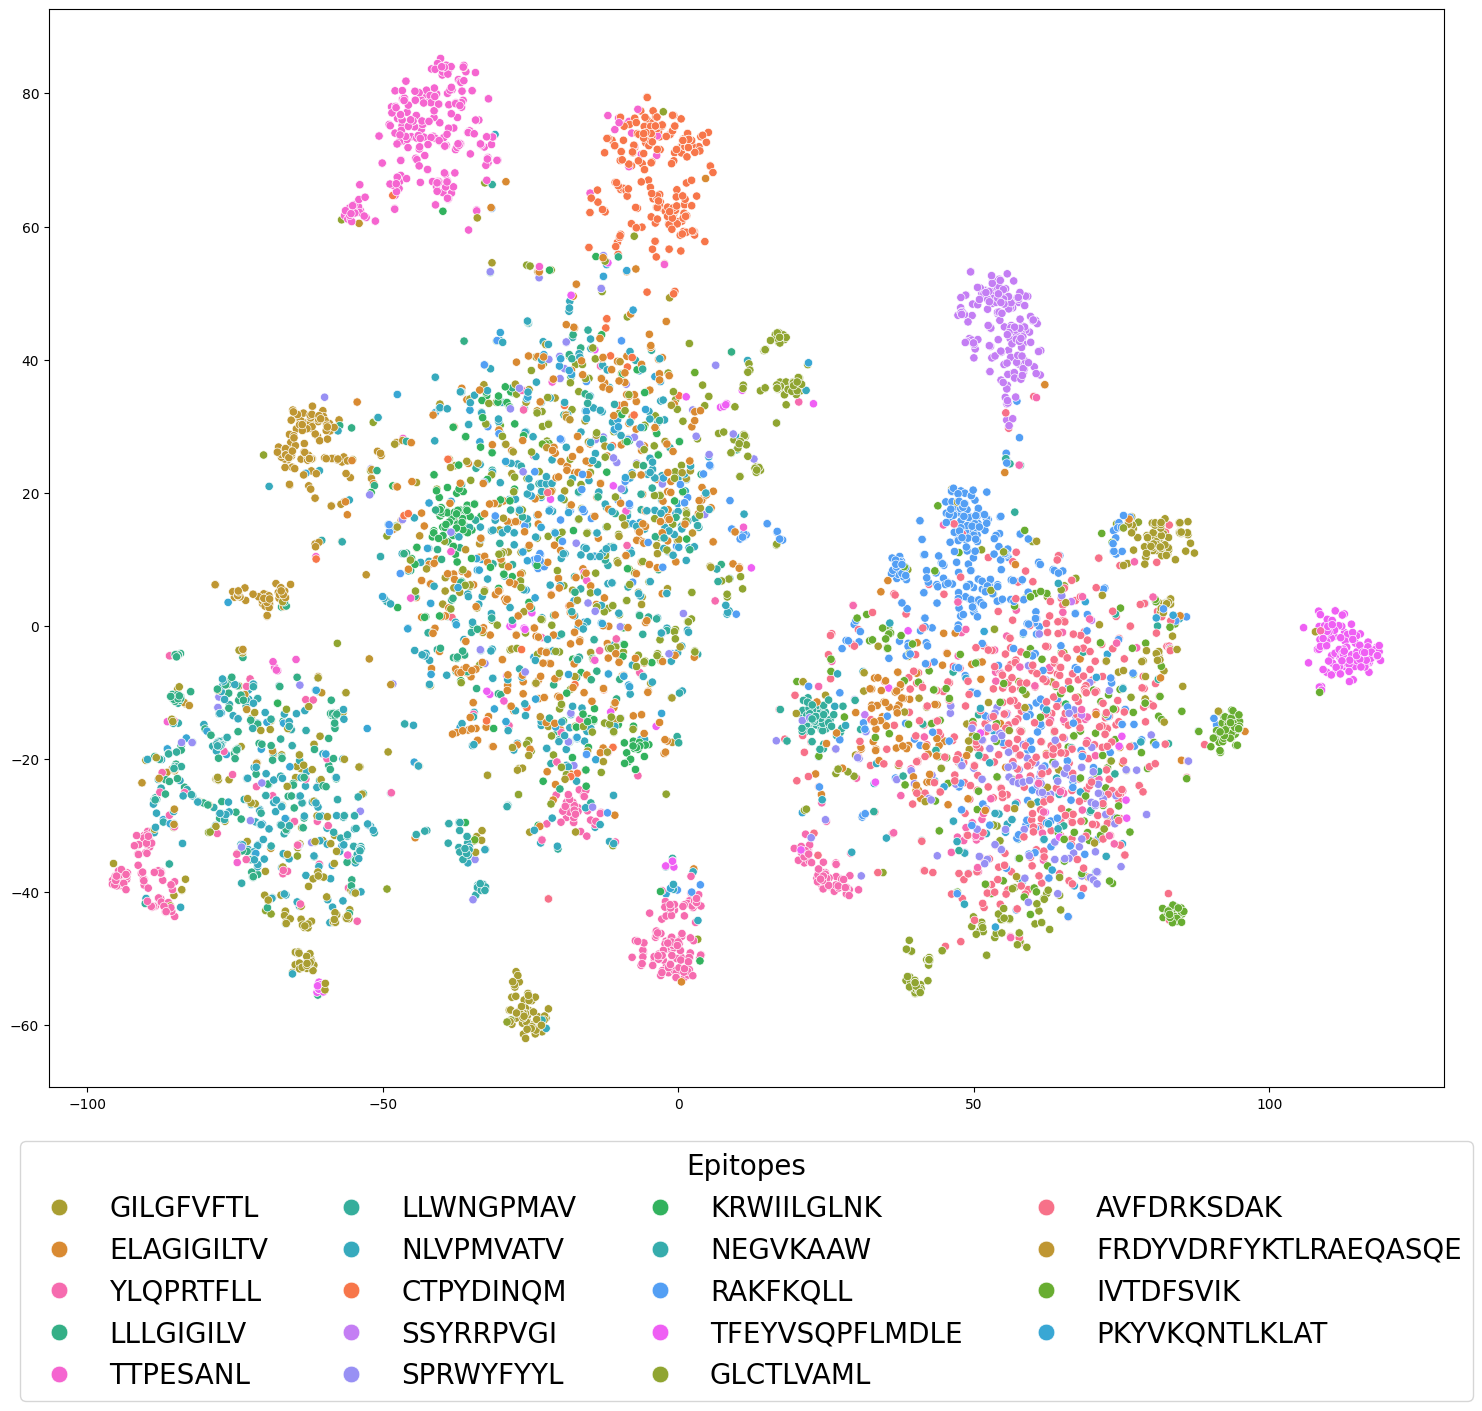

In [66]:
unique_labels = np.unique(le.inverse_transform(labels))
palette = sns.color_palette("husl", n_colors=len(unique_labels))
color_map = dict(zip(unique_labels, palette))

plt.figure(figsize=(18,14))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=le.inverse_transform(labels),
    palette=color_map,
    legend="full",
    alpha=1
)

# plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol = 1)
plt.legend(
    bbox_to_anchor=(0.5, -0.05),
    loc='upper center',
    borderaxespad=0.,
    fontsize=20,
    title='Epitopes',
    title_fontsize=20,
    markerscale=2,
    ncols=4
)

plt.savefig('../imgs/epitopes/All_chain.png')

In [82]:
from sklearn.preprocessing import MinMaxScaler
from natsort import natsorted


def alphanumeric_sort(gene):
    return [int(i) if i.isdigit() else i.lower() for i in re.split(r'(\d+)', gene)]

def draw_heatmap(pred_labels, ans, l_e, n_cl = None, show=True, save_dir=None, label = "Матрица ошибок для альфа V генов"):
    pred_genes = l_e.inverse_transform(pred_labels)
    ans_genes = l_e.inverse_transform(list(ans))
    
    if not n_cl:
        classes = l_e.classes_
    else:
        classes = l_e.classes_[:n_cl]
    
    matrix = pd.DataFrame(data = 0, columns= classes, index= classes)
    for i in range(len(ans_genes)):
        matrix.loc[ans_genes[i], pred_genes[i]] += 1
    
    matrix_norm = MinMaxScaler().fit_transform(matrix.T)
    matrix_norm = pd.DataFrame(data = matrix_norm.T, columns= classes, index= classes)
    matrix_norm = matrix_norm.reindex(index=natsorted(matrix_norm.index, key=alphanumeric_sort))
    matrix_norm = matrix_norm[natsorted(matrix_norm.columns, key=alphanumeric_sort)]
    
    if show:
        plt.rcParams.update({
            'xtick.labelsize': 15,  
            'ytick.labelsize': 15})
        
        fig, ax = plt.subplots(figsize=(11,9)) 
        
        sns.heatmap(matrix_norm, cmap="Greens")
        plt.title(label)
        if save_dir is not None:
            plt.savefig(save_dir)
    return matrix_norm

def norm(dist_matr):
    
    dfmax, dfmin = np.array(dist_matr).max(), np.array(dist_matr).min()

    dist_matr_norm = (dist_matr - dfmin)/(dfmax - dfmin)

    return dist_matr_norm

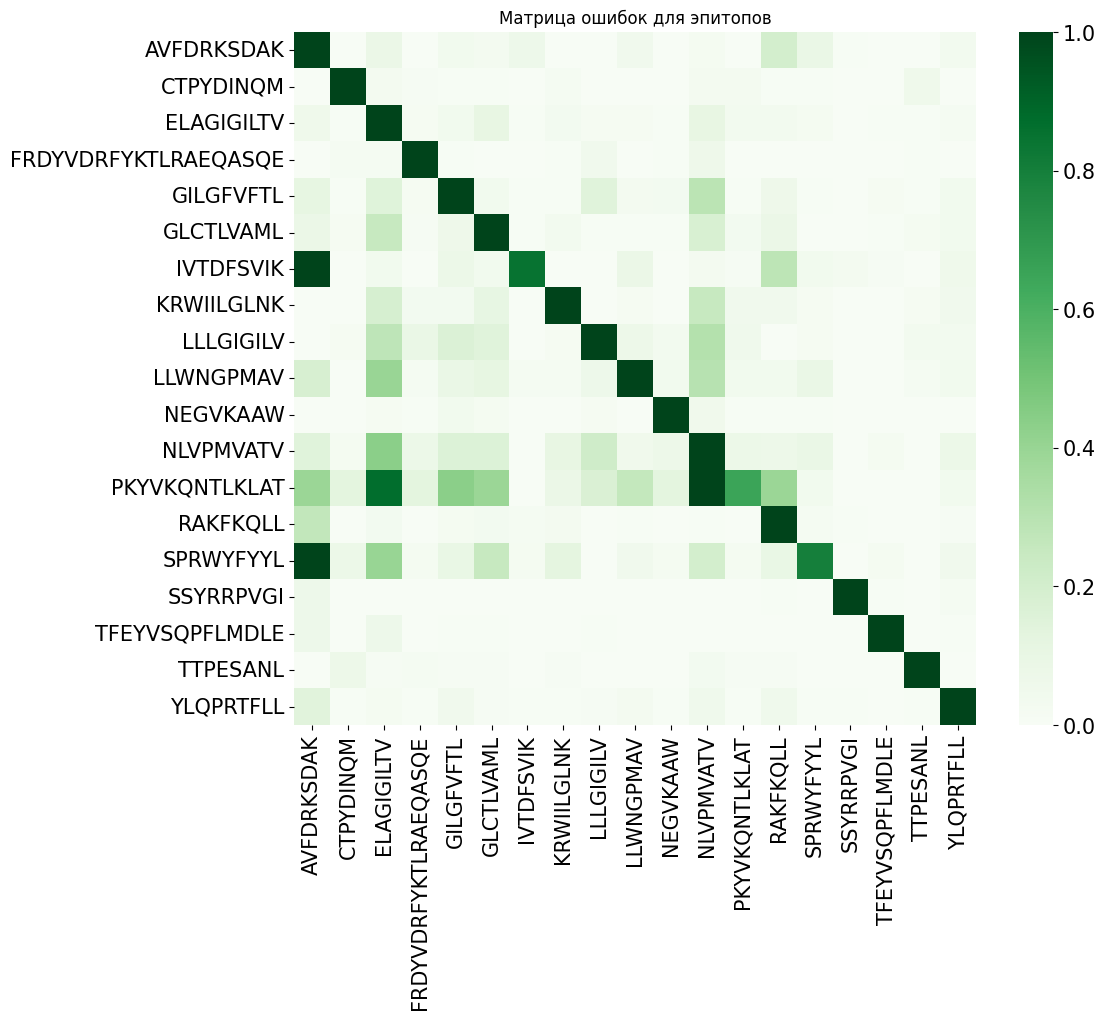

In [83]:
notm_matrix_epit = draw_heatmap(pred_labels, ans.values, le, n_cl=19, label='Матрица ошибок для эпитопов')
# save_dir='imgs/VJ_vis/heatmap_bv.png',

### Prottrans

In [45]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(vdjb_cdr_train, test_size=0.2, random_state=42)

In [46]:
train_df = train_df.rename({'cdr3aa': 'sequence', 'antigen.epitope': 'label'}, axis=1)
val_df = val_df.rename({'cdr3aa': 'sequence', 'antigen.epitope': 'label'}, axis=1)
train_df["sequence"]=train_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
val_df["sequence"]=val_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
    
val_df

,sequence,label
3477,C A E S T G K L I F F F L K E N T G G T G V S C,6
13144,F T Y G Y A A G T Q Y S S A C,1
1688,C A V R D I R D N F N K F Y F F Y Q E Y L D G ...,5
1456,F F A E T N V S T T Q S S A C,5
10434,F Y Q E Y A G V D V S C,16
...,...,...
8904,C A V S N Y Q L I W,14
5999,F Y Q T D G G S A R H S S A C,9
8093,F Y Q I N K A L P G G A I L S S A C,12
7234,C A T D A D N N N A P R F F T Y D S N S S S A C,11


In [47]:
N_LABELS = vdjb_cdr['antigen.epitope'].nunique()

tokenizer, model, history = train_per_protein(train_df, val_df, num_labels=N_LABELS, batch=32, accum=8, epochs=13, seed=42)

Some weights of the model checkpoint at Rostlab/prot_t5_xl_uniref50 were not used when initializing T5EncoderModel: ['decoder.block.6.layer.1.layer_norm.weight', 'decoder.block.20.layer.0.SelfAttention.o.weight', 'decoder.block.5.layer.1.EncDecAttention.v.weight', 'decoder.block.0.layer.0.SelfAttention.q.weight', 'decoder.block.21.layer.1.EncDecAttention.k.weight', 'decoder.block.5.layer.1.EncDecAttention.q.weight', 'decoder.block.0.layer.1.EncDecAttention.q.weight', 'decoder.block.5.layer.0.SelfAttention.q.weight', 'decoder.block.12.layer.0.SelfAttention.q.weight', 'decoder.block.12.layer.0.SelfAttention.o.weight', 'decoder.block.2.layer.0.SelfAttention.q.weight', 'decoder.block.9.layer.1.layer_norm.weight', 'decoder.block.1.layer.0.SelfAttention.k.weight', 'decoder.block.20.layer.0.SelfAttention.q.weight', 'decoder.block.3.layer.1.EncDecAttention.o.weight', 'decoder.block.5.layer.1.layer_norm.weight', 'decoder.block.16.layer.0.SelfAttention.k.weight', 'decoder.block.19.layer.1.EncDec

ProtT5_Classfier
Trainable Parameter: 1209210899
ProtT5_LoRA_Classfier
Trainable Parameter: 3576851

[2024-05-09 21:40:51,283] [INFO] [comm.py:637:init_distributed] cdb=None
[2024-05-09 21:40:51,284] [INFO] [comm.py:668:init_distributed] Initializing TorchBackend in DeepSpeed with backend nccl
[2024-05-09 21:40:51,324] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed info: version=0.14.0, git-hash=unknown, git-branch=unknown
[2024-05-09 21:40:53,415] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed Flops Profiler Enabled: False
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadl

Using /home/akabalina/.cache/torch_extensions/py39_cu117 as PyTorch extensions root...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Detected CUDA files, patching ldflags
Emitting ninja build file /home/akabalina/.cache/torch_extensions/py39_cu117/cpu_adam/build.ninja...
Building extension module cpu_adam...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
ninja: no work to do.
Time to load cpu_adam op: 3.976714611053467 seconds
[2024-05-09 21:41:01,678] [INFO] [logging.py:96:log_dist] [Rank 0] Using DeepSpeed Optimizer param name adamw as basic optimizer


Loading extension module cpu_adam...


[2024-05-09 21:41:01,680] [INFO] [logging.py:96:log_dist] [Rank 0] Removing param_group that has no 'params' in the basic Optimizer
[2024-05-09 21:41:01,726] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed Basic Optimizer = DeepSpeedCPUAdam
[2024-05-09 21:41:01,726] [INFO] [utils.py:56:is_zero_supported_optimizer] Checking ZeRO support for optimizer=DeepSpeedCPUAdam type=<class 'deepspeed.ops.adam.cpu_adam.DeepSpeedCPUAdam'>
[2024-05-09 21:41:01,727] [INFO] [logging.py:96:log_dist] [Rank 0] Creating torch.float32 ZeRO stage 2 optimizer
[2024-05-09 21:41:01,727] [INFO] [stage_1_and_2.py:149:__init__] Reduce bucket size 200000000
[2024-05-09 21:41:01,728] [INFO] [stage_1_and_2.py:150:__init__] Allgather bucket size 200000000
[2024-05-09 21:41:01,728] [INFO] [stage_1_and_2.py:151:__init__] CPU Offload: True
[2024-05-09 21:41:01,729] [INFO] [stage_1_and_2.py:152:__init__] Round robin gradient partitioning: False
Adam Optimizer #0 is created with AVX512 arithmetic capability.
Config: alp

***** Running training *****
  Num examples = 13568
  Num Epochs = 13
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 256
  Gradient Accumulation steps = 8
  Total optimization steps = 689
  Number of trainable parameters = 3576851


Epoch,Training Loss,Validation Loss,Accuracy
1,2.610600,2.369242,0.251695
2,2.155200,2.062723,0.348659
3,1.891200,1.856189,0.407014
4,1.750400,1.777245,0.433834
5,1.661200,1.701354,0.457707
6,1.589700,1.631175,0.477454
7,1.534000,1.599132,0.489537
8,1.481200,1.570608,0.507221
9,1.437000,1.555439,0.503095
10,1.396700,1.530507,0.514294


***** Running Evaluation *****
  Num examples = 3393
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3393
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3393
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3393
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3393
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3393
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3393
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3393
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3393
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3393
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3393
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3393
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3393
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/mod

In [48]:
# tokenizer, model = load_model_('../models_ft/prottrans_epit.pth', num_labels=N_LABELS)

In [49]:
test_set=create_dataset(tokenizer, list(test_dataset['cdr3aa']),list(ans))

test_set = test_set.with_format("torch", device=device)
test_dataloader = DataLoader(test_set, batch_size=8, shuffle=False)


model.eval()

# Make predictions on the test dataset
predictions = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        #add batch results(logits) to predictions
        predictions += model(input_ids, attention_mask=attention_mask).logits.tolist()

100%|██████████| 236/236 [00:21<00:00, 11.14it/s]


In [84]:
predictions= [item.argmax() for item in np.array(predictions)]
f1_prottr = f1_score(list(ans), predictions, average='macro')
print("F1 score: ", f1_prottr)


F1 score:  0.51428459068723


In [51]:
save_model(model, '../models_ft/prottrans_epit.pth')

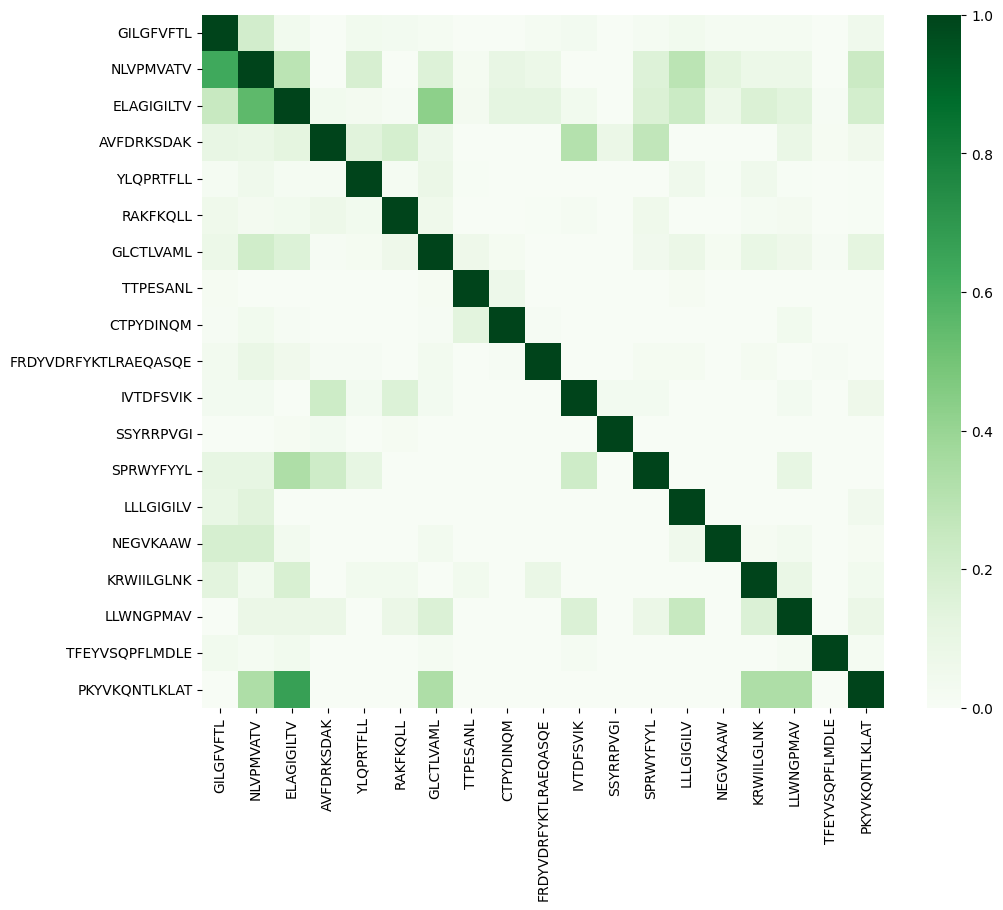

In [53]:
draw_heatmap(ans, predictions, le, N_LABELS, return_mtr=False)